In [1]:
# !pip install transformers accelerate datasets diffusers Pillow==9.4.0

# Imagenet-1k-recaptioned with AR
* center cropping breaks a lot of images
* instead, define aspect ratios, including portrait and lanscape
* resize image to closest AR (mult. of 32px)
* aspect crop
* store in HF dataset, for each image include AR info
* remove augmentations again

In [2]:
import torchvision.transforms as T
import torch
import random
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from diffusers import AutoencoderDC
from torch.utils.data import DataLoader
from utils import make_grid, PIL_to_latent, latent_to_PIL, dcae_scalingf
from tqdm import tqdm

from PIL import PngImagePlugin
# otherwise might lead to Decompressed Data Too Large for some images
LARGE_ENOUGH_NUMBER = 10
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# from local_secrets import hf_token
# from huggingface_hub import login
# login(token=hf_token)

# Load IN1k recaptions dataset

In [4]:
ds = load_dataset("visual-layer/imagenet-1k-vl-enriched", cache_dir="~/ssd-2TB/hf_cache")
ds

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/205 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 50000
    })
})

In [5]:
print("splits", ds.keys())
print("features", ds["train"].features.keys())

splits dict_keys(['train', 'validation'])
features dict_keys(['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'])


## Inspect augmentation before actually processing

image dimension (600, 800)


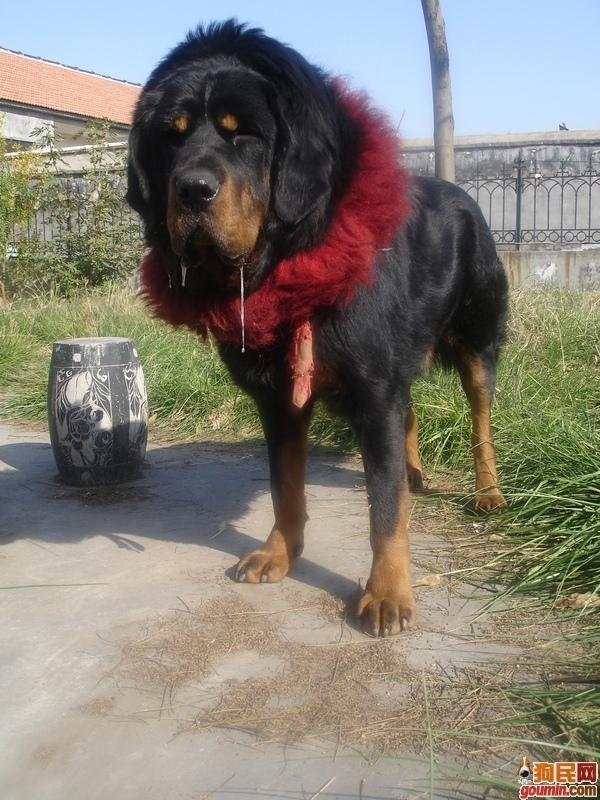

Cropping portrait 128 x 160
a large dog wearing a red collar and fur



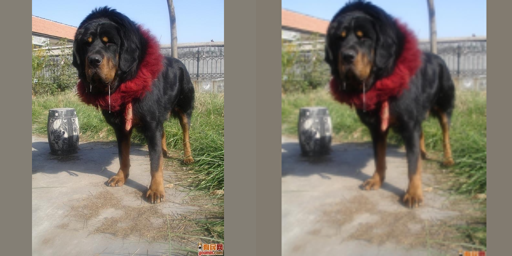

image dimension (650, 480)


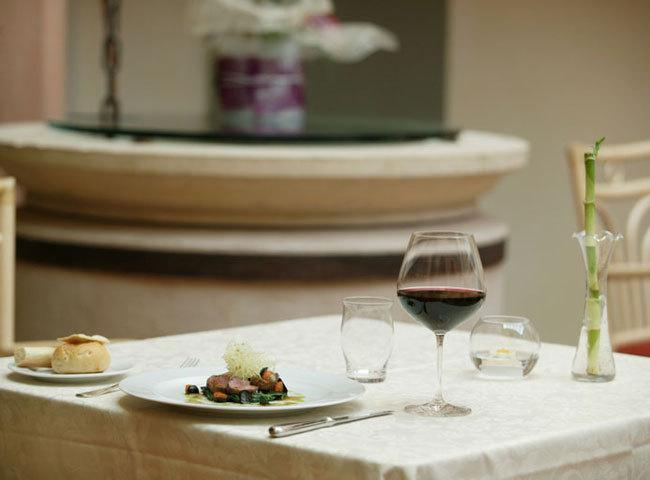

Cropping landscape 160 x 128
a table with a glass of wine and a plate of food



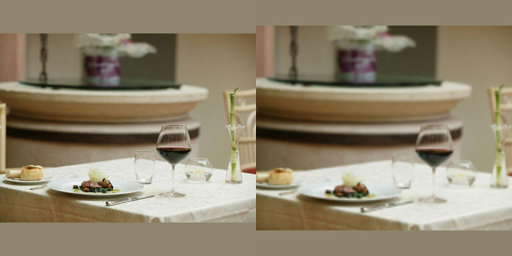

image dimension (440, 576)


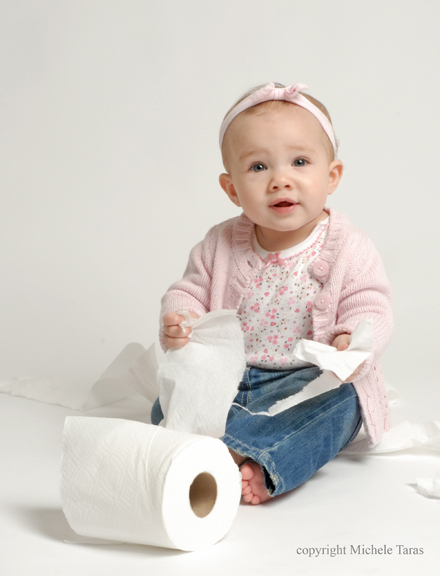

Cropping portrait 128 x 160
a baby girl sitting on the floor with a roll of toilet paper



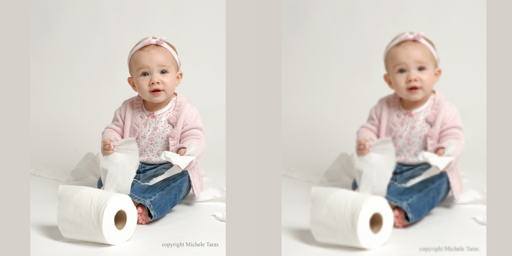

image dimension (287, 192)


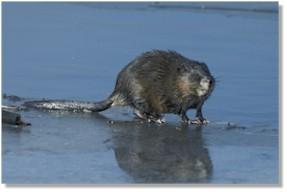

Cropping landscape 160 x 128
a beaver walking on the ice in the water



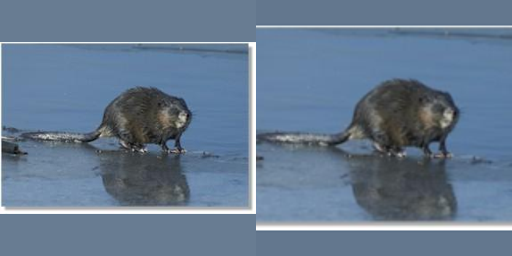

image dimension (500, 333)


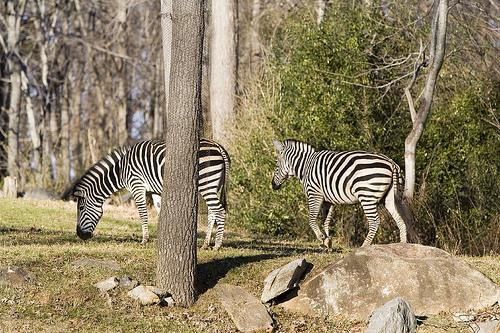

Cropping landscape 160 x 128
two zebras grazing on grass



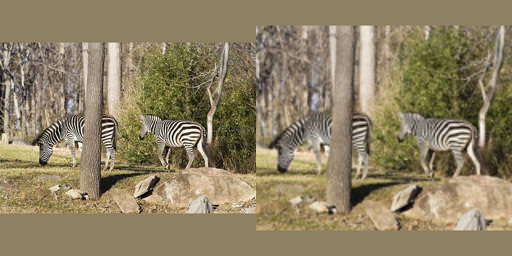

image dimension (333, 500)


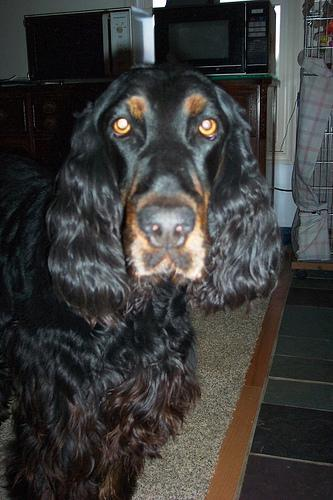

Cropping portrait 128 x 160
a black and brown dog



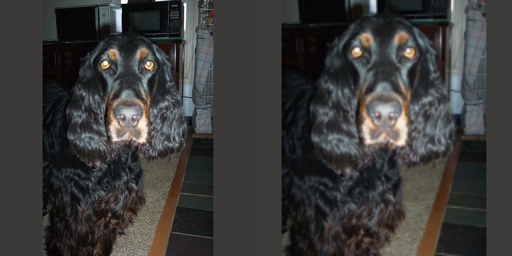

image dimension (500, 375)


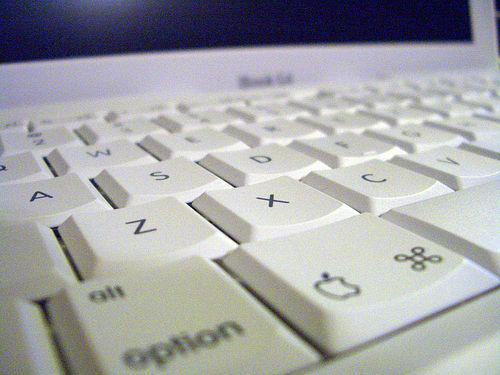

Cropping landscape 160 x 128
a white keyboard on a laptop computer



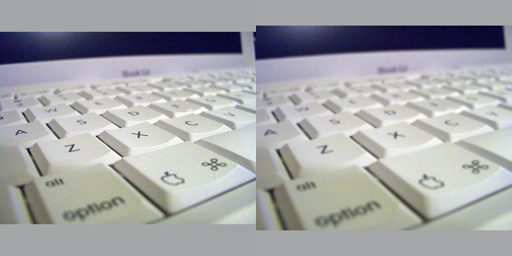

image dimension (500, 375)


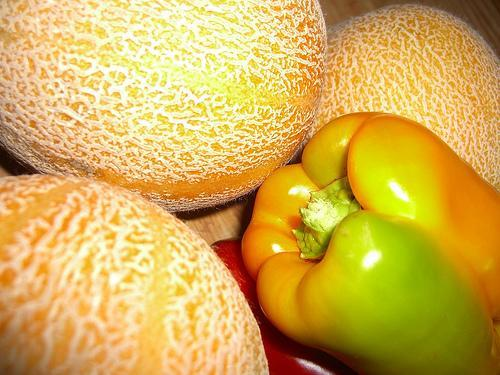

Cropping landscape 160 x 128
a melon, a bell pepper, and a yellow pepper



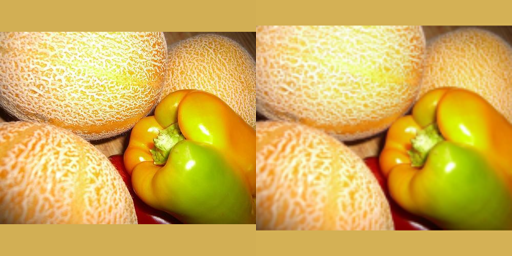

image dimension (500, 334)


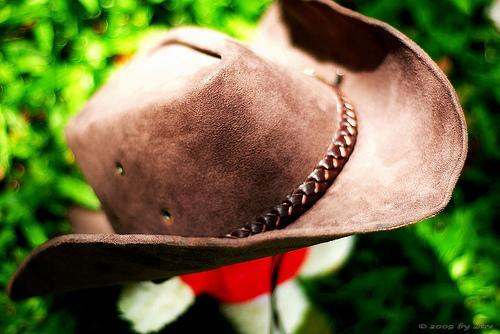

Cropping landscape 160 x 128
a brown hat



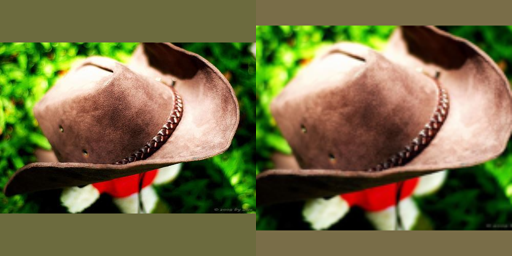

image dimension (500, 375)


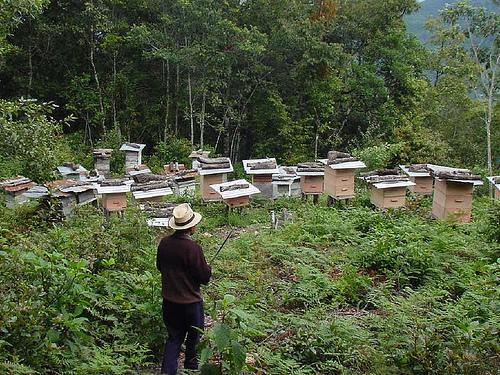

Cropping landscape 160 x 128
a man standing in front of a large group of beehives



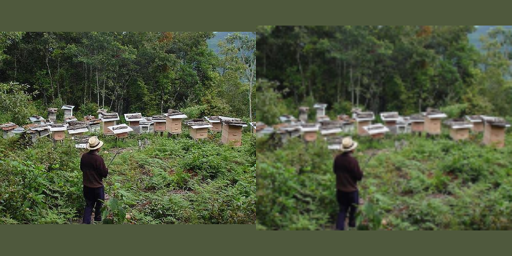

In [7]:
resizeTo = 128
split = "train"

ASPECT_RATIOS = [
    ("AR_1_to_1", 1),
    ("AR_4_to_3", 4/3),
    ("AR_3_to_4", 3/4),
]

def pad(img):
    w, h = img.size
    diff = abs(w-h)
    transform = T.Pad([0, diff//2] if w>h else [diff//2, 0], fill=get_average_color(img))
    return transform(img)

def get_average_color(img):
    img_array = np.array(img)
    return tuple(map(int, img_array.mean(axis=(0,1))))

# DC-AE compression factor=32
def closest_mult_of(num, denominator=32):
    return int(num//denominator) * denominator

def closest_ar_bucket(img):
    w, h = img.size
    ar = w/h
    arbucket_diff = [abs(ar-ar_bucket) for ar_label, ar_bucket in ASPECT_RATIOS]
    arbucket_idx = arbucket_diff.index(min(arbucket_diff))
    return ASPECT_RATIOS[arbucket_idx]

def resize(img, debug=False):
    def noop(x): return x
    img = img.convert('RGB') if img.mode!="RGB" else img
    # smallest side to (resizeTo)px
    img = T.Resize(resizeTo, antialias=True)(img)
    # find closest aspect ratio bucket
    ar_name, ar = closest_ar_bucket(img)

    # Center crop 128x128, 128x?? or ??x128
    if ar == 1:
        # square
        if debug: print("Cropping square")
        img = T.CenterCrop(resizeTo)(img)
    elif ar>1:
        # landscape -> crop new_width x 128
        new_w = closest_mult_of(ar * resizeTo)
        if debug: print("Cropping landscape",new_w,"x",resizeTo)
        img = T.CenterCrop((resizeTo, new_w))(img)   # CenterCrop takes (h, w) !!
    else:
        # portrait -> crop 128 x new_height
        new_h = closest_mult_of(1/ar * resizeTo)
        if debug: print("Cropping portrait",resizeTo,"x",new_h)
        img = T.CenterCrop((new_h, resizeTo))(img)
            
    return ar_name, img
    
for i in [random.randint(0, len(ds[split])) for _ in range(10)]:
    img=ds[split][i]["image"]
    label=ds[split][i]["caption_enriched"]

    print("image dimension", img.size)
    display(img)

    images = []
    images.append( pad(img).resize((256,256)) )
    images.append( pad(resize(img, debug=True)[1]).resize((256,256)) )

    print(label)
    display(make_grid(images))

# Load DCAE

In [8]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# Batch augment and create dataset

In [ ]:
test_run = True
hf_dataset = "g-ronimo/IN1k96-AR-buckets-latents_dc-ae-f32c32-sana-1.0"
dcae_batch_size = 512
upload_every = 100_000
splits=["train", "validation"]
dtype=torch.bfloat16
col_img="image"
col_label="caption_enriched"

def process_dcae_batch(batch):
    labels = batch["labels"]
    images = batch["images"]
    latents = PIL_to_latent(images, dcae).cpu()   
    return [
        dict(label=label, latent = latents[None,i])
        for i, label in enumerate(labels)
    ]

for split in splits:
    dataset_list = {}   # list of dicts per AR bucket, each containing list of {label=.., latent=..}
    parts_uploaded = {}   # dict of int per AR bucket
    dcae_batches = {}   # buffer, collect samples and batch process when full
    samples_uploaded = 0

    for i, d in tqdm(enumerate(ds[split]), total=len(ds[split]), desc=f"Processing split {split}"):
        img=d[col_img]
        label=d[col_label]
        ar_bucket, img = resize(img)

        # fill dcae batches 
        if not ar_bucket in dcae_batches: dcae_batches[ar_bucket]={"labels": [], "images": []}
        dcae_batches[ar_bucket]["labels"].append(label)
        dcae_batches[ar_bucket]["images"].append(img)
        del ar_bucket

        # process batch if full or at the end, store latents in dataset_list[{split}_{ar_bucket}]
        ar_buckets = list(dcae_batches.keys())
        for ar_bucket in ar_buckets:
            if (
                # batch is full -> process
                len(dcae_batches[ar_bucket]["labels"]) >= dcae_batch_size  
                or 
                # batch is not full but we reached end of dataset -> process
                (
                    i == len(ds[split])-1 
                    and len(dcae_batches[ar_bucket]["labels"]) > 0
                )
            ):
                latents = process_dcae_batch(dcae_batches[ar_bucket])
                target_split = f"{split}_{ar_bucket}"     # name of split the images of this batch belong to
                if target_split not in dataset_list:
                    dataset_list[target_split] = []                
                dataset_list[target_split].extend(latents)

                # empty the dcae batch we just processed
                dcae_batches[ar_bucket]={"labels": [], "images": []}

        # upload everything to HF if we reached upload_every or at the end of dataset
        target_splits = list(dataset_list.keys())
        for target_split in target_splits:
            if (
                # processed enough -> upload
                len(dataset_list[target_split]) >= upload_every
                or (
                    # reached end of dataset -> upload
                    i == len(ds[split])-1
                    and len(dataset_list[target_split]) > 0
                )
            ):
                if target_split not in parts_uploaded: 
                    parts_uploaded[target_split]=0
                Dataset.from_list(dataset_list[target_split]).push_to_hub(
                    hf_dataset, split=f"{target_split}.part_{parts_uploaded[target_split]}", num_shards=1
                )
                parts_uploaded[target_split]+=1
                samples_uploaded += len(dataset_list[target_split])
                print("Uploaded",len(dataset_list[target_split]), "samples of split", target_split, "part", parts_uploaded[target_split])
                dataset_list[target_split]=[]   

    print("split", split, "total samples uploaded:", samples_uploaded)

Processing split train:  12%|█        | 150273/1281167 [18:20<45:48, 411.42it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/101 [00:00<?, ?ba/s]

Processing split train:  12%|▋     | 150357/1281167 [20:01<167:49:22,  1.87it/s]

Uploaded 100352 samples of split train_AR_4_to_3 part 1


Processing split train:  23%|██       | 300532/1281167 [37:20<47:52, 341.34it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/101 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/427 [00:00<?, ?B/s]

Processing split train:  23%|█▍    | 300575/1281167 [39:06<205:30:42,  1.33it/s]

Uploaded 100352 samples of split train_AR_4_to_3 part 2


Processing split train:  34%|██▎    | 434628/1281167 [54:47<1:03:43, 221.43it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/101 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/584 [00:00<?, ?B/s]

Processing split train:  34%|██    | 434670/1281167 [56:47<195:02:18,  1.21it/s]

Uploaded 100352 samples of split train_AR_3_to_4 part 1


Processing split train:  35%|███▏     | 450294/1281167 [58:43<32:41, 423.50it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/101 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/741 [00:00<?, ?B/s]

Processing split train:  35%|█▍  | 450374/1281167 [1:00:23<123:07:35,  1.87it/s]

Uploaded 100352 samples of split train_AR_4_to_3 part 3


Processing split train:  36%|█▊   | 464080/1281167 [1:01:58<1:09:21, 196.36it/s]

In [85]:
dataset_list.keys()

dict_keys(['train_AR-4-to-3', 'validation_AR-4-to-3'])

split train_AR-4-to-3
a close up of a car with a window
 torch.Size([1, 32, 4, 5])


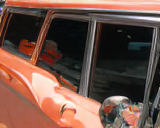

a man on a beam in the middle of a competition
 torch.Size([1, 32, 4, 5])


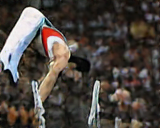

a car parked in front of a bridge
 torch.Size([1, 32, 4, 5])


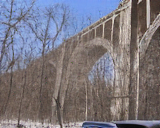

a car accident with people in the front seat
 torch.Size([1, 32, 4, 5])


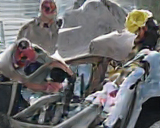

a man is making a pottery vase on a potter wheel
 torch.Size([1, 32, 4, 5])


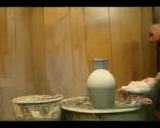

a black squash growing in the ground
 torch.Size([1, 32, 4, 5])


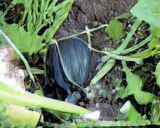

a dog laying on the grass with a stick
 torch.Size([1, 32, 4, 5])


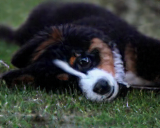

a hard drive with a sticker on it
 torch.Size([1, 32, 4, 5])


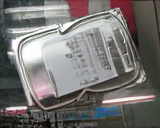

a plate with chocolate and fruit on it
 torch.Size([1, 32, 4, 5])


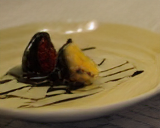

a close up of a square shaped light fixture
 torch.Size([1, 32, 4, 5])


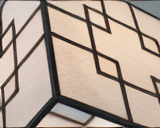

golden piggy bank with a blue face
 torch.Size([1, 32, 4, 5])


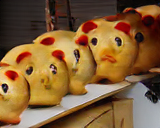

a student works on a crossword puzzle
 torch.Size([1, 32, 4, 5])


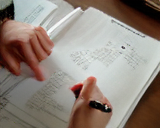

split validation_AR-4-to-3
a fish in a tank
 torch.Size([1, 32, 4, 5])


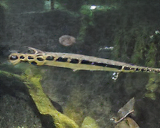

a small dog playing with a purple toy
 torch.Size([1, 32, 4, 5])


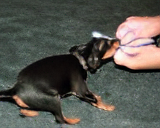

a person holding a camera lens
 torch.Size([1, 32, 4, 5])


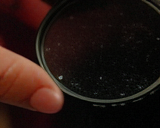

a dog laying on a wooden floor
 torch.Size([1, 32, 4, 5])


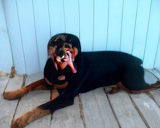

a view of a mountain town with a clock tower
 torch.Size([1, 32, 4, 5])


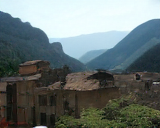

a white canopy bed
 torch.Size([1, 32, 4, 5])


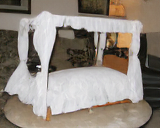

a pile of squash
 torch.Size([1, 32, 4, 5])


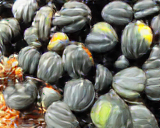

a pile of rusty chains
 torch.Size([1, 32, 4, 5])


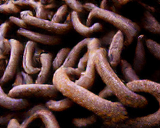

a yellow and black fish swimming in the ocean
 torch.Size([1, 32, 4, 5])


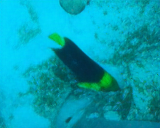

a weasel standing on its hind legs in the grass
 torch.Size([1, 32, 4, 5])


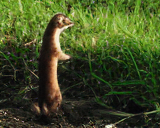

a red and white golf cart
 torch.Size([1, 32, 4, 5])


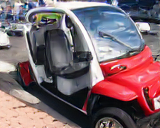

a drum stick with a logo on it
 torch.Size([1, 32, 4, 5])


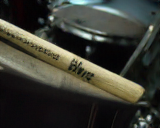

In [91]:
# check a few samples
num_samples = 12
dataset = dataset_list
for split in dataset:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(num_samples)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label, latent.shape)
        display(
            make_grid(
                [latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)]
            )
        )

# Upload

In [ ]:
# dataset = DatasetDict({
#     split: Dataset.from_list(dataset_latents[split]) 
#     for split in dataset_latents
# })
# dataset

In [ ]:
# # check a few samples
# for split in splits:
#     print("split", split)
#     for idx in [random.randint(0, len(dataset[split])-1) for _ in range(5)]:
#         latent = torch.Tensor(dataset[split][idx]["latent"])
#         label = dataset[split][idx]["label"]
#         print(label, latent.shape)
#         display(
#             make_grid(
#                 latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
#             )
#         )

In [ ]:
# from local_secrets import hf_token
# from huggingface_hub import login
# login(token=hf_token)

In [ ]:
# dataset.push_to_hub(
#     "g-ronimo/IN1k96-augmented-latents_dc-ae-f32c32-sana-1.0", 
#     private=True, 
#     commit_message=model,
#     num_shards={'train': 10, 'validation': 4}
# )